In [9]:
# Project: Hyperparameter Tuning and Prediction of Reliance Stock Market Price using Sentiment Analysis
# Model: FinBERT + LSTM
# Author: Pranshu Rajan, Divyansh Patel, Yug Patel

# Phase 0: Imports & Device Setup
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [10]:
# Phase 1: Load Datasets
stock_df = pd.read_csv("C:/Users/pranshu/Desktop/Reliance_stock_prediction_project/data/reliance_stock_history.csv")
stock_df["date"] = pd.to_datetime(stock_df["date"]).dt.date

news_df = pd.read_csv("C:/Users/pranshu/Desktop/Reliance_stock_prediction_project/data/reliance_news_sentiment.csv")
news_df["date"] = pd.to_datetime(news_df["date"]).dt.date

print("Stock data shape:", stock_df.shape)
print("News data shape:", news_df.shape)

Stock data shape: (52, 6)
News data shape: (653, 6)


C:\Users\pranshu\AppData\Local\Temp\ipykernel_13168\3605828885.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  stock_df["date"] = pd.to_datetime(stock_df["date"]).dt.date


In [11]:
# Phase 2: Load Fine-Tuned FinBERT
finbert_path = "C:/Users/pranshu/Desktop/Reliance_stock_prediction_project/models/finetuned_finbert_model"
tokenizer = AutoTokenizer.from_pretrained(finbert_path)
finbert_model = AutoModelForSequenceClassification.from_pretrained(finbert_path).to(device)
finbert_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
# Phase 3: Generate Daily Sentiment
def get_finbert_sentiment(texts, batch_size=16):
    all_scores = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        encodings = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = finbert_model(**encodings)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
        all_scores.extend(probs)
    return np.array(all_scores)

news_texts = news_df["title"].tolist()
sentiment_probs = get_finbert_sentiment(news_texts, batch_size=16)

news_df["finbert_pos"] = sentiment_probs[:, 0]
news_df["finbert_neutral"] = sentiment_probs[:, 1]
news_df["finbert_neg"] = sentiment_probs[:, 2]

daily_sentiment = news_df.groupby("date").agg({
    "finbert_pos": "mean",
    "finbert_neutral": "mean",
    "finbert_neg": "mean"
}).reset_index()

data_df = pd.merge(stock_df, daily_sentiment, on="date", how="left")
data_df.fillna(0, inplace=True)
print("Merged dataset shape:", data_df.shape)
print(data_df.head())

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Merged dataset shape: (52, 9)
         date         open         high          low        close   volume  \
0  2021-10-21  2727.399902  2728.000000  2603.199951  2622.500000  9612230   
1  2021-10-22  2620.000000  2664.899902  2611.500000  2627.399902  5086641   
2  2021-10-25  2680.000000  2680.000000  2570.000000  2601.800049  7934786   
3  2021-10-26  2617.100098  2668.899902  2603.149902  2661.050049  4498720   
4  2021-10-27  2652.000000  2676.800049  2619.949951  2627.399902  4565815   

   finbert_pos  finbert_neutral  finbert_neg  
0     0.623583         0.221107     0.155309  
1     0.716217         0.279314     0.004469  
2     0.814731         0.167988     0.017281  
3     0.755287         0.228708     0.016005  
4     0.699616         0.200341     0.100044  


In [13]:
# Phase 4: Feature Engineering
FEATURES = ["open", "high", "low", "volume", "finbert_pos", "finbert_neutral", "finbert_neg"]
TARGET = "close"

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

data_df[FEATURES] = scaler_X.fit_transform(data_df[FEATURES])
data_df[TARGET] = scaler_y.fit_transform(data_df[[TARGET]])

SEQ_LEN = 5  # number of past days to consider

In [14]:
# Phase 5: Dataset & Model Definition
class StockDataset(Dataset):
    def __init__(self, features, targets, seq_len=SEQ_LEN):
        self.features = features.values.astype(np.float32)
        self.targets = np.array(targets).astype(np.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.features) - self.seq_len

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.seq_len]
        y_val = self.targets[idx + self.seq_len]
        return torch.tensor(x), torch.tensor(y_val)

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [15]:
# Phase 6: Hyperparameter Tuning using Optuna
train_size = int(len(data_df) * 0.8)
train_df = data_df[:train_size]
val_df = data_df[train_size:]

train_dataset = StockDataset(train_df[FEATURES], train_df[TARGET])
val_dataset = StockDataset(val_df[FEATURES], val_df[TARGET])

def objective(trial):
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    epochs = trial.suggest_int("epochs", 20, 60)

    model = StockLSTM(input_size=len(FEATURES),
                      hidden_size=hidden_size,
                      num_layers=num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out.view(-1), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                val_loss = criterion(out.view(-1), yb)
                val_losses.append(val_loss.item())

        avg_val_loss = np.mean(val_losses)
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return avg_val_loss


# Run study (optimize validation loss)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15, timeout=1800)

print("\nBest Hyperparameters Found:")
print(study.best_params)
print("Best Validation Loss:", study.best_value)

[I 2025-10-13 19:59:28,980] A new study created in memory with name: no-name-86e27989-5f81-43a5-abfa-d9511a9c1447
[I 2025-10-13 19:59:29,930] Trial 0 finished with value: 0.00651247613132 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lr': 0.002982985607257159, 'batch_size': 16, 'epochs': 55}. Best is trial 0 with value: 0.00651247613132.
[I 2025-10-13 19:59:32,154] Trial 1 finished with value: 0.007532498333603144 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.009502624196824735, 'batch_size': 32, 'epochs': 38}. Best is trial 0 with value: 0.00651247613132.
[I 2025-10-13 19:59:32,930] Trial 2 finished with value: 0.005849545355886221 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0006655908282657322, 'batch_size': 32, 'epochs': 29}. Best is trial 2 with value: 0.005849545355886221.
[I 2025-10-13 19:59:34,221] Trial 3 finished with value: 0.005832068622112274 and parameters: {'hidden_size': 64, 'num_layers': 3, 'lr': 0.004384701016611934, 'batch_siz


Best Hyperparameters Found:
{'hidden_size': 64, 'num_layers': 3, 'lr': 0.004384701016611934, 'batch_size': 64, 'epochs': 54}
Best Validation Loss: 0.005832068622112274


In [16]:
# Phase 7: Retrain Final Model with Best Hyperparameters
best_params = study.best_params

final_model = StockLSTM(
    input_size=len(FEATURES),
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers']
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'])

train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

EPOCHS = best_params['epochs']
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    final_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = final_model(xb)
        loss = criterion(out.view(-1), yb)
        loss.backward()
        optimizer.step()

    final_model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = final_model(xb)
            val_loss = criterion(out.view(-1), yb)
            val_losses.append(val_loss.item())
    avg_val_loss = np.mean(val_losses)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = final_model.state_dict()

print("\nFinal Training Complete.")
print("Best Validation Loss:", best_val_loss)


Final Training Complete.
Best Validation Loss: 0.005118571687489748


In [17]:
# Phase 8: Prediction & Evaluation
final_model.load_state_dict(best_model_state)
final_model.eval()

preds, true_vals = [], []
all_features = data_df[FEATURES].values.astype(np.float32)
all_targets = data_df[TARGET].values.astype(np.float32)

with torch.no_grad():
    for i in range(len(all_features) - SEQ_LEN):
        x_seq = torch.tensor(all_features[i:i + SEQ_LEN]).unsqueeze(0).to(device)
        pred = final_model(x_seq).cpu().numpy().flatten()[0]
        preds.append(pred)
        true_vals.append(all_targets[i + SEQ_LEN])

# Inverse scaling
preds_rescaled = scaler_y.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
true_rescaled = scaler_y.inverse_transform(np.array(true_vals).reshape(-1, 1)).flatten()

# Evaluation metrics
mae = mean_absolute_error(true_rescaled, preds_rescaled)
mse = mean_squared_error(true_rescaled, preds_rescaled)
rmse = math.sqrt(mse)
r2 = r2_score(true_rescaled, preds_rescaled)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 35.4431
Mean Squared Error (MSE): 2013.2007
Root Mean Squared Error (RMSE): 44.8687
R² Score: 0.6008


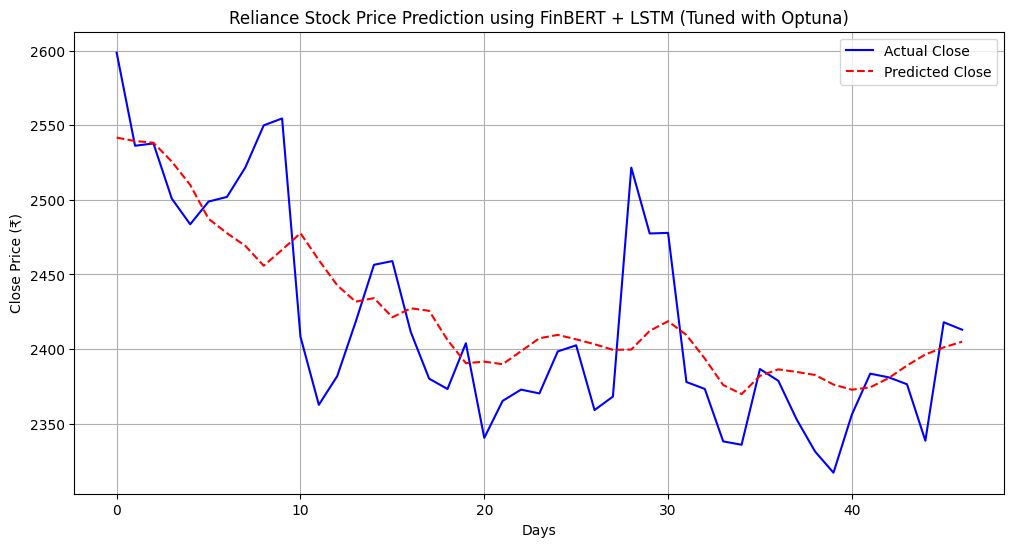

In [18]:
# Phase 9: Visualization
plt.figure(figsize=(12,6))
plt.plot(true_rescaled, label="Actual Close", color='blue')
plt.plot(preds_rescaled, label="Predicted Close", color='red', linestyle='--')
plt.xlabel("Days")
plt.ylabel("Close Price (₹)")
plt.title("Reliance Stock Price Prediction using FinBERT + LSTM (Tuned with Optuna)")
plt.legend()
plt.grid(True)
plt.show()